## steps to reproduce the issue

### prebuilt Container preparation

Launch a terminal from anywhere in LUMI and run the following to load basic modules and set up an installation directory in your scratch space.


```bash
installdir=/scratch/project_462001088/$USER/DEMO1
cd "$installdir/tmp"
mkdir -p "$installdir" ; cd "$installdir"
mkdir -p "$installdir/tmp" ; cd "$installdir/tmp"
module purge
module load LUMI/24.03 partition/container EasyBuild-user
```


Now I did install the prebuilt PyTorch container with the following commands:


```bash
eb --copy-ec PyTorch-2.7.1-rocm-6.2.4-python-3.12-singularity-20250827.eb PyTorch-2.7.1-rocm-6.2.4-python-3.12-Mycontainer-singularity-20250827.eb

sed -e "s|^\(versionsuffix.*\)-singularity-\(.*\)|\1-Mycontainer-singularity-\2|" -i PyTorch-2.7.1-rocm-6.2.4-python-3.12-Mycontainer-singularity-20250827.eb

eb PyTorch-2.7.1-rocm-6.2.4-python-3.12-Mycontainer-singularity-20250827.eb



```

Then I ceated a definition file to extend the prebuilt container with my custom code and dependencies with the following command

```bash
cat > lumi-pytorch-rocm-6.2.4-python-3.12-pytorch-v2.7.1-Mycontainer.def <<EOF

Bootstrap: localimage

From: $CONTAINERFILE

%post

zypper -n install -y Mesa libglvnd libgthread-2_0-0 hostname

%appinstall mawm
cd /projappl/project_462001088/
git clone https://github.com/Ahmed-Khaled-Saleh/mawm.git
cd mawm
pip install -r requirements.txt # install dependencies
pip install -e . # install mawm itself

EOF

```

### Batch job script

I then submit a batch job to build the container. 

```bash
#!/bin/bash -l
#SBATCH --job-name=setup   # Job name
#SBATCH --output=setup.o%j # Name of stdout output file
#SBATCH --error=setup.e%j  # Name of stderr error file
#SBATCH --partition=small       # Partition name
#SBATCH --ntasks=1              # One task (process)
#SBATCH --mem=224G              # Memory request
#SBATCH --time=01:30:00         # Run time (hh:mm:ss)
#SBATCH --account=project_462001088  # Project for billing


installdir=/scratch/project_462001088/$USER/DEMO1
cd "$installdir/tmp"
module purge
module load LUMI/24.03

module load PyTorch/2.7.1-rocm-6.2.4-python-3.12-Mycontainer-singularity-20250827

export CONTAINERFILE="$SIF"
module unload PyTorch/2.7.1-rocm-6.2.4-python-3.12-Mycontainer-singularity-20250827

module load systools/24.03

singularity build --force $CONTAINERFILE lumi-pytorch-rocm-6.2.4-python-3.12-pytorch-v2.7.1-Mycontainer.def

```

This successfully created the .sif file in the EasyBuild installation directory.

### Installing additional packages

Load the modules including the custom container:


```bash
module purge
module load LUMI/24.03 systools/24.03
module load PyTorch/2.7.1-rocm-6.2.4-python-3.12-Mycontainer-singularity-20250827

```

```bash
cd /projappl/project_462001088
singularity shell $SIF
git clone https://github.com/Ahmed-Khaled-Saleh/mawm.git
cd mawm
pip install -r requirements.txt # install dependencies
pip install -e . # install mawm itself
``` 

NOTE: I set my PYTHONUSERBASE as:

```bash
export PYTHONUSERBASE=/user-software/venv/pytorch/
``` 

### Jupyter notebook testing

Launch a jupyter notebook from the apps in LUMI with the `advanced` option in setting and the following:

- In the `custom python type` chose `container`. 

- In `modules to load`, put `LUMI/24.03 PyTorch/2.7.1-rocm-6.2.4-python-3.12-Mycontainer-singularity-20250827`. 

- In `Path to container with Python`, put `/projappl/project_462001088/EasyBuild/SW/container/PyTorch/2.7.1-rocm-6.2.4-python-3.12-Mycontainer-singularity-20250827/lumi-pytorch-rocm-6.2.4-python-3.12-pytorch-v2.7.1-dockerhash-0d479e852886.sif`
- In `working directory`, put `/scratch/project_462001088`


![Screenshot from 2026-01-28 10-27-49.png](<attachment:Screenshot from 2026-01-28 10-27-49.png>)
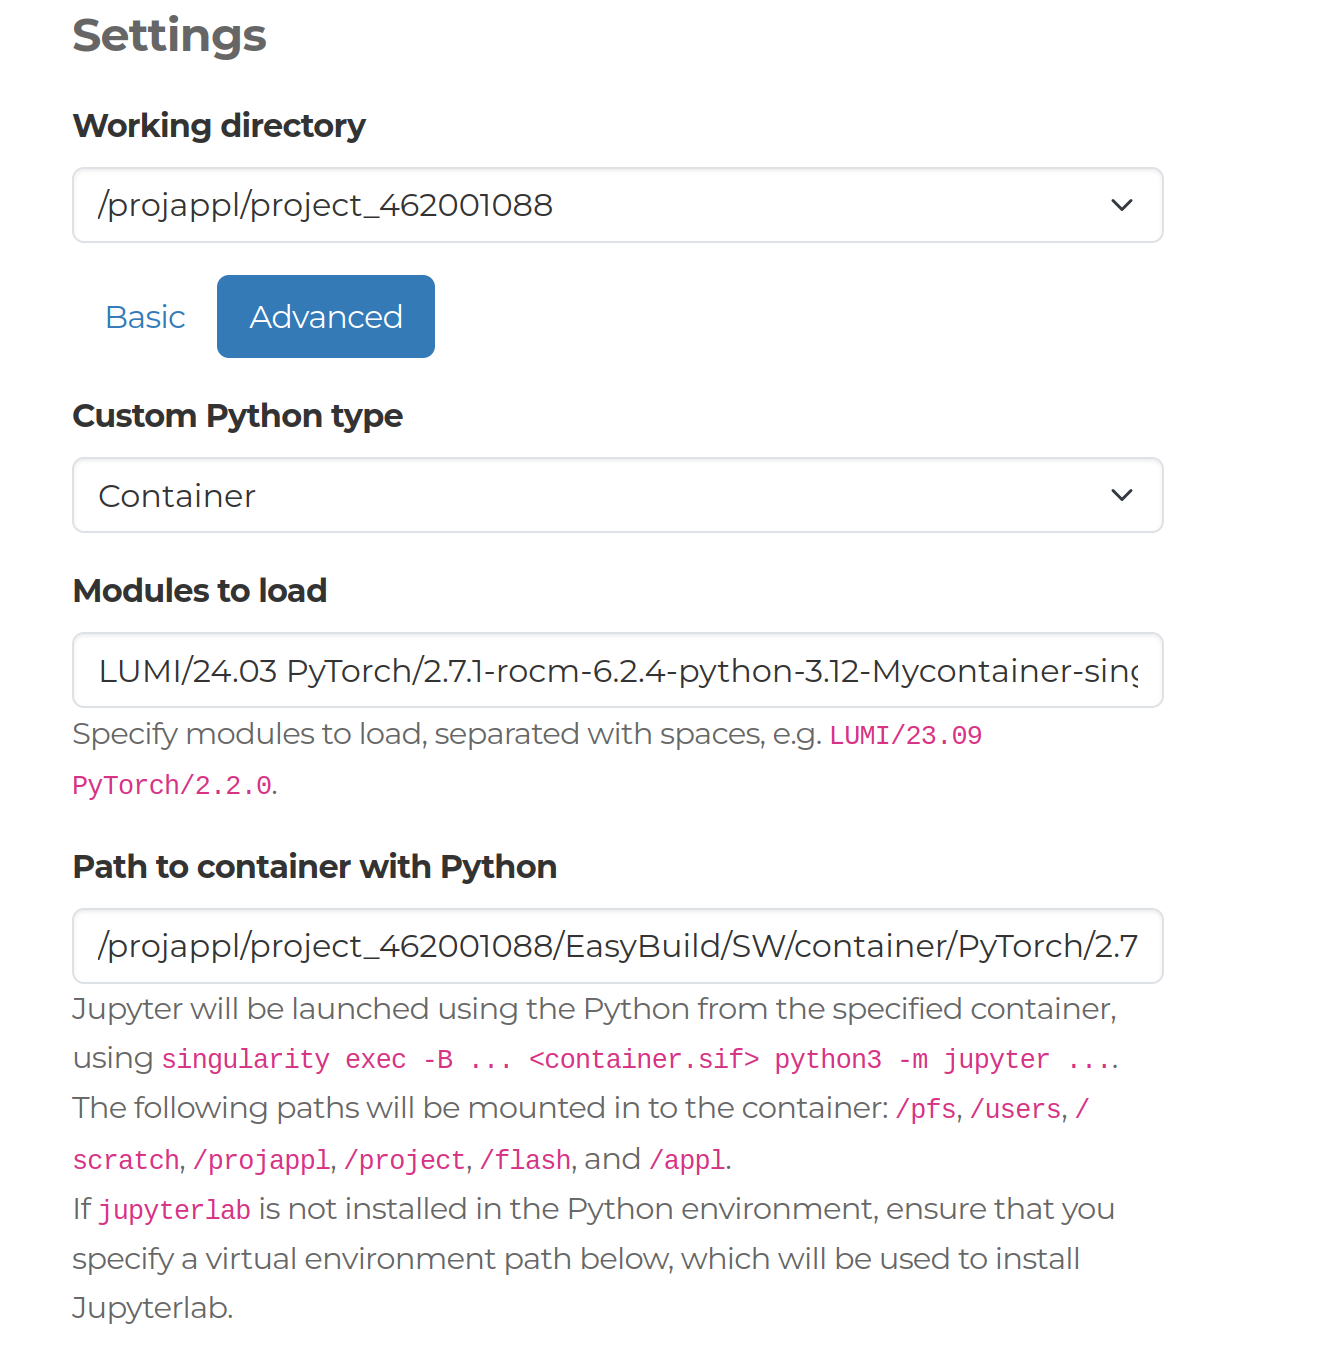

Then launch the notebook job. Once you are in Jupyter notebook, you can test if everything is working by running the following code in a cell:

```python
import mawm
from mawm.models import *
```


Then make a compressed version of the container's packages:
```bash
cd $CONTAINERROOT
make-squashfs
rm -rf $CONTAINERROOT/user-software
```

